In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from helpers import create_csv_submission
from helpers import load_csv_data

# Define wheteher one hot encoding and PCA should be done 
perform_one_hot = True
perform_pca = False

In [2]:
def load_data(CSV_PATH):
    
    # 1) read headers
    with open(CSV_PATH, 'r') as file:
        reader = csv.reader(file)
        feature_names = next(reader)

# 2) load numeric data (skip header row)
    X = np.genfromtxt(
        CSV_PATH,
        delimiter=",",
        skip_header=1,
        dtype=float,
    )
    
    return X, feature_names


def plot_missingness(X):
    
    # 3) compute % missing
    missing_pct = np.isnan(X).mean(axis=0) * 100
    thresholds = np.arange(0, 101, 5)
    feature_counts = [(missing_pct <= threshold).sum() for threshold in thresholds]

    plt.figure(figsize=(10, 6))
    plt.bar(thresholds, feature_counts, color='b', width=4)
    plt.xlabel('Threshold % of missing data')
    plt.ylabel('Number of features with at most x% missing data')
    plt.title('Number of features with at most x% missing data')
    plt.xticks(thresholds)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig("plot.png", dpi=300)
    plt.show()
    
    return 

def compute_missing(X, feature_names,threshold_percent):

    # keep features with ≤ threshold % missing
    missing_pct = np.isnan(X).mean(axis=0) * 100
    mask_threshold = missing_pct <= threshold_percent
    X_rem_missing = X[:, mask_threshold]
    feature_names_rem_missing = [name for i, name in enumerate(feature_names) if mask_threshold[i]]

    return X_rem_missing, feature_names_rem_missing

def remove_cols(X, feature_names, cols_to_remove):
    
    remove_idx = [i for i, name in enumerate(feature_names) if name in cols_to_remove]
    X_reduced = np.delete(X, remove_idx, axis=1)
    feature_names_reduced = [name for i, name in enumerate(feature_names) if i not in remove_idx]

    print("Final shape:", X_reduced.shape)
    print("Remaining features:", len(feature_names_reduced))
    print("kept features:", feature_names_reduced)

    return X_reduced, feature_names_reduced

def apply_semantics(col, name):
    # map special "None" codes to a real value first (e.g., 0 days)
    code = SPECIAL_TO_ZERO.get(name)
    if code is not None:
        col = col.astype(float, copy=True)
        col[col == float(code)] = 0.0
    return col

def apply_missing_codes(col, name):
    """
    Replace coded missings with NaN. Uses a big default set,
    overridden by SPECIAL_MISS where needed.
    """
    col = col.astype(float, copy=True)
    codes = np.array(SPECIAL_MISS.get(name, DEFAULT_MISS), dtype=float)
    if codes.size:
        col[np.isin(col, codes)] = np.nan
    return col

def clean_data(X_reduced,feature_names_reduced):
    
    for j, name in enumerate(feature_names_reduced):
        col = X_reduced[:, j]
        col = apply_missing_codes(col, name)
        col = apply_semantics(col, name)
        X_reduced[:, j] = col
    
    return X_reduced

def plot_unique_counts(
    X, feature_names,
    top_n=None,               # e.g., 50 to show top 50 by uniqueness; None = all
    sort_desc=True,           # sort by unique count
    filename="unique_counts.png"
):
    X = np.asarray(X, dtype=float)
    n, p = X.shape

    uniq_counts = []
    prop_unique = []
    for j in range(p):
        col = X[:, j]
        v = col[~np.isnan(col)]
        k = np.unique(v).size
        uniq_counts.append(k)
        prop_unique.append(k / max(len(v), 1))

    uniq_counts = np.array(uniq_counts)
    prop_unique = np.array(prop_unique)

    idx = np.arange(p)
    if sort_desc:
        idx = np.argsort(-uniq_counts)
    if top_n is not None:
        idx = idx[:top_n]

    labels = [feature_names[i] for i in idx]
    vals   = uniq_counts[idx]

    # --- bar plot (horizontal for readability) ---
    plt.figure(figsize=(10, max(6, 0.35*len(idx))))
    plt.barh(np.arange(len(idx)), vals)
    plt.yticks(np.arange(len(idx)), labels)
    plt.gca().invert_yaxis()
    plt.xlabel("# unique (non-NaN)")
    plt.title("Unique values per column")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    
    # --- quick console table ---
    print("Column | #unique | %unique_of_nonmissing")
    for i in idx:
        print(f"{feature_names[i]:<20s} {uniq_counts[i]:>8d} {prop_unique[i]*100:>9.2f}%")

    return uniq_counts, prop_unique

def impute_plan(
    X, feature_names,
    abs_unique_cap=76,           # if #unique < abs_unique_cap  -> categorical (mode)
    rel_unique_cap=0.04,         # if %unique < rel_unique_cap  -> categorical (mode)
    singleton_ratio_thresh=0.60, # if ≥ threshold occur once    -> numeric (median)
    force_mode=None,             # e.g., {"_STATE","EXRACT11","EXRACT21"}
    force_median=None
):
    X = np.asarray(X, dtype=float)
    force_mode   = set(force_mode or [])
    force_median = set(force_median or [])

    plan = {}
    for j, name in enumerate(feature_names):
        # overrides by name
        if name in force_mode:
            plan[name] = "mode";   continue
        if name in force_median:
            plan[name] = "median"; continue

        col = X[:, j]
        v = col[~np.isnan(col)]
        if v.size == 0:
            plan[name] = "mode";   continue

        uniq, cnt = np.unique(v, return_counts=True)
        k = uniq.size
        prop_unique = k / v.size
        singleton_ratio = (cnt == 1).sum() / k

        if k < 20:
            plan[name] = "mode"
        elif (k < abs_unique_cap) and (prop_unique > rel_unique_cap) and (singleton_ratio <= singleton_ratio_thresh):
            plan[name] = "mode"
        else:
            plan[name] = "median"

    # split once, preserving feature order
    mode_cols   = [n for n in feature_names if plan.get(n) == "mode"]
    median_cols = [n for n in feature_names if plan.get(n) == "median"]
    return mode_cols, median_cols

def impute_mean(arr):
    mask = np.isnan(arr)
    if np.all(mask):  # nothing to learn
        return arr
    arr[mask] = np.nanmean(arr)
    return arr

def impute_median(arr):
    v = arr[~np.isnan(arr)]
    if v.size == 0: return np.nan
    return np.nanmedian(v)

def impute_mode(arr):
    v = arr[~np.isnan(arr)]
    if v.size == 0: return np.nan
    u, c = np.unique(v, return_counts=True)
    return u[np.argmax(c)]

def impute(X, feature_names, mode_list, median_list,save_path):
    """
    X: np.ndarray (n_samples, n_features) — numeric (float ok)
    feature_names: list of column names in the same order as X
    Returns cleaned+imputed copy of X (float).
    """
    X = np.array(X, dtype=float, copy=True)
    p = X.shape[1]
    fillers = np.full(p, np.nan, dtype=float)

    for j, name in enumerate(feature_names):
        col = X[:, j]

        if name in mode_list:
            fill = impute_mode(col)
        elif name in median_list:
            fill = impute_median(col)
        fillers[j] = fill

        # impute TRAIN with learned filler
        if not np.isnan(fill):
            m = np.isnan(col)
            if np.any(m):
                col[m] = fill
        X[:, j] = col

    # save to npz
    np.savez(save_path, fillers=fillers.astype(float),
             feature_names=np.array(feature_names, dtype=object))

    return X, fillers

def _ensure_npz(path):
    return path if path.endswith(".npz") else (path + ".npz")

def load_imputer(save_path):
    """
    Load per-column fillers learned on TRAIN.
    Returns (train_feature_names, fillers) in the TRAIN order.
    """
    d = np.load(_ensure_npz(save_path), allow_pickle=True)
    train_names = list(d["feature_names"])
    fillers = d["fillers"].astype(float)
    assert len(train_names) == fillers.shape[0], "Saved names/fillers length mismatch."
    return train_names, fillers

def apply_imputer_to_test(X_test, feature_names_test, save_path):
    """
    Impute NaNs in X_test using TRAIN fillers stored at save_path (.npz).
    - Matches by column name.
    - strict=True -> requires identical feature set.
    Returns an imputed copy of X_test.
    """
    X_test = np.array(X_test, dtype=float, copy=True)
    train_names, fillers = load_imputer(save_path)

    # Build name→index maps
    te_idx = {n: i for i, n in enumerate(feature_names_test)}
    tr_idx = {n: i for i, n in enumerate(train_names)}

    
    # Apply fillers for overlapping columns
    common = [n for n in feature_names_test if n in tr_idx]
    for n in common:
        j_te = te_idx[n]
        j_tr = tr_idx[n]
        fill = fillers[j_tr]
        if np.isfinite(fill):
            m = np.isnan(X_test[:, j_te])
            if np.any(m):
                X_test[m, j_te] = fill

    return X_test

# 1) Identify which of your mode-impute columns are binary vs need OHE
def identify_cat_cols(X, feature_names, mode_cols, verbose=True):
    """
    Returns:
      binary_cols : list[str]  (2 distinct non-NaN values or all-NaN -> treat as binary)
      ohe_cols    : list[str]  (>=3 distinct non-NaN values)
      constant    : list[str]  (1 distinct non-NaN value)
    """
    X = np.asarray(X, dtype=float)
    name2idx = {n:i for i,n in enumerate(feature_names)}
    binary_cols, ohe_cols, constant_cols = [], [], []

    for name in mode_cols:
        j = name2idx.get(name)
        if j is None:
            if verbose: print(f"[warn] {name} not found; skipping.")
            continue
        v = np.unique(X[:, j][~np.isnan(X[:, j])])
        k = v.size
        if k == 0:        # all NaN in this split
            binary_cols.append(name)
        elif k == 1:      # constant
            constant_cols.append(name)
        elif k == 2:      # binary
            binary_cols.append(name)
        else:             # multi-class -> OHE
            ohe_cols.append(name)

    if verbose:
        print(f"[identify] binary={len(binary_cols)}, ohe={len(ohe_cols)}, constant={len(constant_cols)}")
    return binary_cols, ohe_cols, constant_cols


# 2) Build binary 0/1 matrix from a list of column names
def build_binary_matrix(X, feature_names, binary_cols):
    """
    Deterministically maps two-level columns to 0/1:
      smaller value -> 0, larger -> 1
      all-NaN -> zeros; single-level -> (col == level)
    Returns: X_bin (n x b), bin_names
    """
    X = np.asarray(X, dtype=float)
    name2idx = {n:i for i,n in enumerate(feature_names)}
    blocks, names = [], []
    for name in binary_cols:
        j = name2idx.get(name)
        if j is None: continue
        col = X[:, j]
        vals = np.unique(col[~np.isnan(col)])
        if vals.size == 0:
            b = np.zeros((X.shape[0],1), float)
        elif vals.size == 1:
            b = (col == vals[0]).astype(float).reshape(-1,1)
        else:
            vmin, vmax = float(vals.min()), float(vals.max())
            b = np.where(col == vmin, 0.0, np.where(col == vmax, 1.0, np.nan)).reshape(-1,1)
        blocks.append(b); names.append(name)
    X_bin = np.concatenate(blocks, axis=1) if blocks else np.zeros((X.shape[0],0))
    return X_bin, names


## 3) Fit OHE on train for given ohe_cols and SAVE ONLY the vocab/model (not the lists)
def fit_ohe_and_save(
    X, feature_names, ohe_cols,
    save_path="artifacts/onehot_model.npz",
    include_missing=True, use_other=True, min_count=1, drop_first=False, verbose=True
):
    """
    Returns: X_ohe (train OHE block), ohe_names
    Saves:   onehot_model.npz with vocab + settings (to reuse on test)
    """
    X = np.asarray(X, dtype=float)
    name2idx = {n:i for i,n in enumerate(feature_names)}
    vocab = {}        # {col_name: [(label,value), ...]} incl __MISSING__/__OTHER__
    blocks, ohe_names = [], []

    for col_name in ohe_cols:
        j = name2idx.get(col_name)
        if j is None: continue
        col = X[:, j]
        m = np.isnan(col)
        levels, counts = np.unique(col[~m], return_counts=True)
        kept = np.sort(levels[counts >= min_count].astype(float))

        entries = []
        if include_missing: entries.append(("__MISSING__", np.nan))
        if use_other:       entries.append(("__OTHER__", "__OTHER__"))
        for v in kept:
            lab = str(int(v)) if float(v).is_integer() else str(v)
            entries.append((lab, float(v)))
        vocab[col_name] = entries

        kept_set = set(kept.tolist())
        B_cols, names = [], []
        for lab, val in entries:
            if lab == "__MISSING__":
                hit = np.isnan(col)
            elif lab == "__OTHER__":
                hit = (~np.isnan(col)) & (~np.array([vv in kept_set for vv in col]))
            else:
                hit = (~np.isnan(col)) & (col == val)
            B_cols.append(hit.astype(float).reshape(-1,1))
            names.append(f"{col_name}__{lab}")
        B = np.concatenate(B_cols, axis=1) if B_cols else np.zeros((X.shape[0],0))
        if drop_first and B.shape[1] > 0:
            B, names = B[:,1:], names[1:]
        blocks.append(B); ohe_names.extend(names)

    X_ohe = np.concatenate(blocks, axis=1) if blocks else np.zeros((X.shape[0],0))

    # --- save OHE model (vocab + settings) using NAMED keys (fixes empty vocab on load) ---
    save_payload = dict(
        feature_names=np.array(feature_names, dtype=object),
        cols_to_ohe=np.array(ohe_cols, dtype=object),
        include_missing=np.array([int(include_missing)]),
        use_other=np.array([int(use_other)]),
        min_count=np.array([min_count]),
        drop_first=np.array([int(drop_first)])
    )
    for col_name, entries in vocab.items():
        save_payload[f"VOCAB__{col_name}"] = np.array(entries, dtype=object)

    np.savez(save_path, **save_payload)
    if verbose:
        print(f"[save] OHE vocab for {len(ohe_cols)} cols → {save_path}")

    return X_ohe, ohe_names


# 4) Apply the saved OHE model to TEST data
def apply_saved_ohe(X, feature_names, load_path="data/dataset/onehot_model.npz", strict=True):
    """
    Returns: X_ohe_test, ohe_names (same order as on train)
    """
    X = np.asarray(X, dtype=float)
    d = np.load(load_path, allow_pickle=True)
    feat_train      = list(d["feature_names"])
    cols_to_ohe     = list(d["cols_to_ohe"])
    include_missing = bool(d["include_missing"][0])
    use_other       = bool(d["use_other"][0])
    drop_first      = bool(d["drop_first"][0])

    if strict and feature_names != feat_train:
        raise ValueError("Feature name/order mismatch vs OHE model.")

    # rebuild vocab (now present as named arrays like 'VOCAB__COLNAME')
    vocab = {}
    for k in d.files:
        if k.startswith("VOCAB__"):
            col_name = k.split("VOCAB__")[1]
            vocab[col_name] = [(pair[0], pair[1]) for pair in d[k]]

    print(vocab)  # (kept as in your original)

    name2idx = {n:i for i,n in enumerate(feature_names)}
    blocks, ohe_names = [], []

    for col_name in cols_to_ohe:
        j = name2idx[col_name]
        col = X[:, j]
        entries = vocab[col_name]
        kept_vals = [val for (lab,val) in entries if lab not in ("__MISSING__","__OTHER__")]
        kept_set  = set(kept_vals)

        B_cols, names = [], []
        for lab, val in entries:
            if lab == "__MISSING__":
                hit = np.isnan(col)
            elif lab == "__OTHER__":
                hit = (~np.isnan(col)) & (~np.array([v in kept_set for v in col]))
            else:
                hit = (~np.isnan(col)) & (col == val)
            B_cols.append(hit.astype(float).reshape(-1,1))
            names.append(f"{col_name}__{lab}")
        B = np.concatenate(B_cols, axis=1) if B_cols else np.zeros((X.shape[0],0))
        if drop_first and B.shape[1] > 0:
            B, names = B[:,1:], names[1:]
        blocks.append(B); ohe_names.extend(names)

    X_ohe = np.concatenate(blocks, axis=1) if blocks else np.zeros((X.shape[0],0))
    return X_ohe, ohe_names


# extract numeric columns for further analyses 
def extract_columns_by_name(X, feature_names, wanted_names, strict=True):
    """
    Extract columns from X whose names are in wanted_names (in that order).

    X             : (n x p) array
    feature_names : list[str] length p
    wanted_names  : list[str] columns to extract (by name, order preserved)
    strict        : if True, raise if any wanted name is missing

    Returns:
      X_sub       : (n x k) array with selected columns
      names_sub   : list[str] of selected names (same as resolved wanted_names)
      idx_sub     : list[int] indices into original feature_names
      missing     : list[str] names not found (empty if strict=True)
    """
    X = np.asarray(X)
    name_to_idx = {n: i for i, n in enumerate(feature_names)}

    idx_sub, names_sub, missing = [], [], []
    for n in wanted_names:
        j = name_to_idx.get(n)
        if j is None:
            missing.append(n)
            if strict:
                raise KeyError(f"Column not found: {n}")
            continue
        idx_sub.append(j)
        names_sub.append(n)

    X_sub = X[:, idx_sub] if idx_sub else np.zeros((X.shape[0], 0))
    return X_sub, names_sub, idx_sub, missing

def plot_heat_map(X, features):
    
    # 1) Correlation (Pearson), safe for constant columns
    corr_matrix = np.corrcoef(X, rowvar=False)

    # 2) Simple heatmap (matplotlib only)
    plt.figure(figsize=(20, 16))
    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Correlation Coefficient')

    labels = features
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45)
    plt.yticks(ticks=np.arange(len(labels)), labels=labels)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.show()

    return corr_matrix

def high_corr_pairs(C, feature_names, threshold=0.90, top_k=None, label="train"):
    """
    Print and return pairs with |r| >= threshold, sorted by |r| desc.
    C: (p x p) correlation matrix
    feature_names: list[str] length p
    threshold: float (e.g., 0.80, 0.90)
    top_k: optional int to only print/return top_k strongest pairs
    label: optional tag shown in the print header
    """
    C = np.asarray(C, float)
    p = C.shape[0]
    assert p == len(feature_names), "feature_names must align with C's columns"

    iu = np.triu_indices(p, k=1)      # i < j upper triangle
    r = C[iu]
    mask = np.isfinite(r) & (np.abs(r) >= threshold)
    I, J, R = iu[0][mask], iu[1][mask], r[mask]

    # sort strongest first
    order = np.argsort(-np.abs(R))
    I, J, R = I[order], J[order], R[order]

    if top_k is not None:
        I, J, R = I[:top_k], J[:top_k], R[:top_k]

    pairs = [(feature_names[i], feature_names[j], float(R[k]))
             for k, (i, j) in enumerate(zip(I, J))]

    # --- prints ---
    print(f"[high_corr_pairs:{label}] threshold=|r|>={threshold:.2f}  total={len(pairs)}")
    for a, b, r_val in pairs:
        sign = "+" if r_val >= 0 else "-"
        print(f"  {a} ~ {b}   r={r_val:.3f} ({sign})")

    return pairs

def drop_correlated_seconds(X, feature_names, pairs, strict=False):
    """
    Remove the 2nd element in each (a, b, r) pair from X.

    X              : (n x p) array
    feature_names  : list[str] length p
    pairs          : iterable of (feat_a, feat_b, r) OR (feat_a, feat_b)
                     Only 'feat_b' is scheduled for removal.
    strict         : if True, raise if any pair name is missing

    Returns:
      X_reduced, feature_names_reduced, dropped_names, dropped_idx, kept_idx
    """
    X = np.asarray(X)
    assert X.shape[1] == len(feature_names), "X columns must match feature_names length."

    name_to_idx = {n: i for i, n in enumerate(feature_names)}
    to_drop = []
    for tup in pairs:
        if len(tup) >= 2:
            b = tup[1]
        else:
            raise ValueError("Each pair must have at least two elements (a, b).")
        if b not in name_to_idx:
            if strict:
                raise KeyError(f"Feature '{b}' from pairs not found in feature_names.")
            continue
        to_drop.append(name_to_idx[b])

    # unique, sorted indices to drop
    drop_idx = sorted(set(to_drop))
    keep_idx = [i for i in range(len(feature_names)) if i not in set(drop_idx)]

    X_reduced = X[:, keep_idx] if keep_idx else np.zeros((X.shape[0], 0))
    feature_names_reduced = [feature_names[i] for i in keep_idx]
    dropped_names = [feature_names[i] for i in drop_idx]

    return X_reduced, feature_names_reduced, dropped_names, drop_idx, keep_idx

def fit_standardizer(matrix):
    """
    Fit per-feature mean and std. Safe for constant columns.
    Returns a dict with 'mean' and 'std'.
    """
    matrix = np.asarray(matrix, dtype=float)
    mean = matrix.mean(axis=0)
    std  = matrix.std(axis=0, ddof=1)
    std_safe = np.where(std == 0.0, 1.0, std)  # avoid divide-by-zero
    return {"mean": mean, "std": std_safe}

def transform_standardizer(matrix, scaler):
    """
    Apply z-score scaling using a fitted scaler.
    """
    matrix = np.asarray(matrix, dtype=float)
    return (matrix - scaler["mean"]) / scaler["std"]

def save_standardizer(scaler, savepath):
    np.savez(savepath, mean=scaler["mean"], std=scaler["std"])

def load_standardizer(path="scaler_zscore.npz"):
    d = np.load(path, allow_pickle=True)
    return {"mean": d["mean"], "std": d["std"]}

def pca_fit_and_save_train(X_train_std, variance_threshold, model_path, csv_path, row_ids=None, row_id_name="row_id"):
    """
    X_train_std: (n x p) TRAIN matrix (already standardized; no NaNs)
    variance_threshold: e.g. 0.95 (keep PCs explaining >=95% variance)
    model_path: where to save PCA model (.npz)
    csv_path:   where to save projected PCs (.csv)
    row_ids:    optional iterable of length n to prepend as first column
    """
    X = np.asarray(X_train_std, dtype=float)

    # Covariance (symmetric) -> eig
    C = np.cov(X, rowvar=False, ddof=1)
    evals, evecs = np.linalg.eigh(C)          # ascending eigenvalues
    order = np.argsort(evals)[::-1]           # sort descending
    evals = evals[order]
    evecs = evecs[:, order]                   # columns = eigenvectors

    # Choose k by variance threshold
    evr = evals / evals.sum()
    k = int(np.searchsorted(np.cumsum(evr), variance_threshold) + 1)

    # Components and projection
    components = evecs[:, :k]                 # (p x k)
    Z = X @ components                        # (n x k)

    # Save PCA model
    np.savez(
        model_path,
        components=components,
        explained_variance=evals[:k],
        explained_variance_ratio=evr[:k],
        variance_threshold=np.array([variance_threshold]),
        n_features=np.array([X.shape[1]], dtype=int)
    )

    # Save TRAIN projection to CSV
    if row_ids is not None:
        row_ids = np.asarray(row_ids).reshape(-1, 1)
        out = np.concatenate([row_ids, Z], axis=1)
        header = ",".join([row_id_name] + [f"PC{i+1}" for i in range(Z.shape[1])])
    else:
        out = Z
        header = ",".join([f"PC{i+1}" for i in range(Z.shape[1])])

    np.savetxt(csv_path, out, delimiter=",", fmt="%.6f", header=header, comments="")
    return Z  # in case you want it in-memory too


def pca_transform(standardized_data, model_path="pca_model.npz"):
    """
    Apply a previously-fitted PCA to new standardized data (e.g., validation/test).
    """
    X = np.asarray(standardized_data, dtype=float)
    d = np.load(model_path, allow_pickle=True)
    components = d["components"]             # (p x k)
    # sanity: feature count must match
    n_features = int(d["n_features"][0])
    assert X.shape[1] == n_features, f"Expected {n_features} features, got {X.shape[1]}"
    return X @ components


# append numeric with categorical columns 

def make_pc_names(k, prefix="PC"):
    """['PC1', 'PC2', ..., 'PCk']"""
    return [f"{prefix}{i+1}" for i in range(k)]

def concat_design(Z_num, pc_names, X_bin, bin_names, X_ohe, ohe_names, order="pc_first"):
    """
    Rebuild final design matrix by concatenating processed blocks.

    Z_num     : (n x k) PCA scores for numeric features
    pc_names  : list[str] length k
    X_bin     : (n x b) binary 0/1 features (already imputed)
    bin_names : list[str] length b
    X_ohe     : (n x m) one-hot features (already imputed/encoded)
    ohe_names : list[str] length m
    Returns:
      X_final, final_feature_names
    """
    blocks, names = [], []
    if X_bin is not None and X_bin.size:
        blocks.append(X_bin);     names += bin_names
    if X_ohe is not None and X_ohe.size:
        blocks.append(X_ohe);     names += ohe_names
    if Z_num is not None and Z_num.size:
        blocks.append(Z_num);     names += pc_names

    X_final = np.concatenate(blocks, axis=1) if blocks else np.zeros((0,0))
    return X_final, names

Original X 
 (328135, 322)


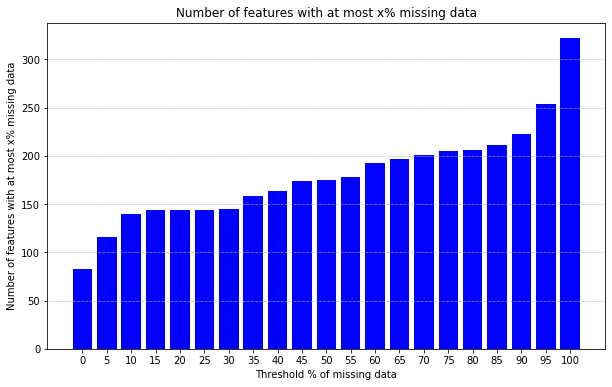

Post missingness X 
 (328135, 164)
Final shape: (328135, 78)
Remaining features: 78
kept features: ['_STATE', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'HLTHPLN1', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BLOODCHO', 'CHOLCHK', 'TOLDHI2', 'CVDSTRK3', 'ASTHMA3', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', 'HAVARTH3', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'SEX', 'MARITAL', 'EDUCA', 'RENTHOM1', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME2', 'INTERNET', 'WEIGHT2', 'HEIGHT3', 'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'USENOW3', 'ALCDAY5', 'FRUITJU1', 'FRUIT1', 'FVBEANS', 'FVGREEN', 'FVORANG', 'VEGETAB1', 'EXERANY2', 'EXRACT11', 'EXEROFT1', 'EXERHMM1', 'EXRACT21', 'STRENGTH', 'SEATBELT', 'FLUSHOT6', 'PNEUVAC3', 'HIVTST6', 'QSTLANG', '_CHISPNC', '_PRACE1', '_MRACE1', '_HISPANC', '_RACE', '_RACEGR3', '_RACE_G1', '_AGEG5YR', '_AGE65YR', '_AGE80', '_AGE_G', 'DROCDY3_', 'MAXVO2_', 'FC60_', 'PADUR1_', 'PAFREQ1_', '_LMTACT1', '_LMTWRK1', '_LMTSCL1']
Post manual r

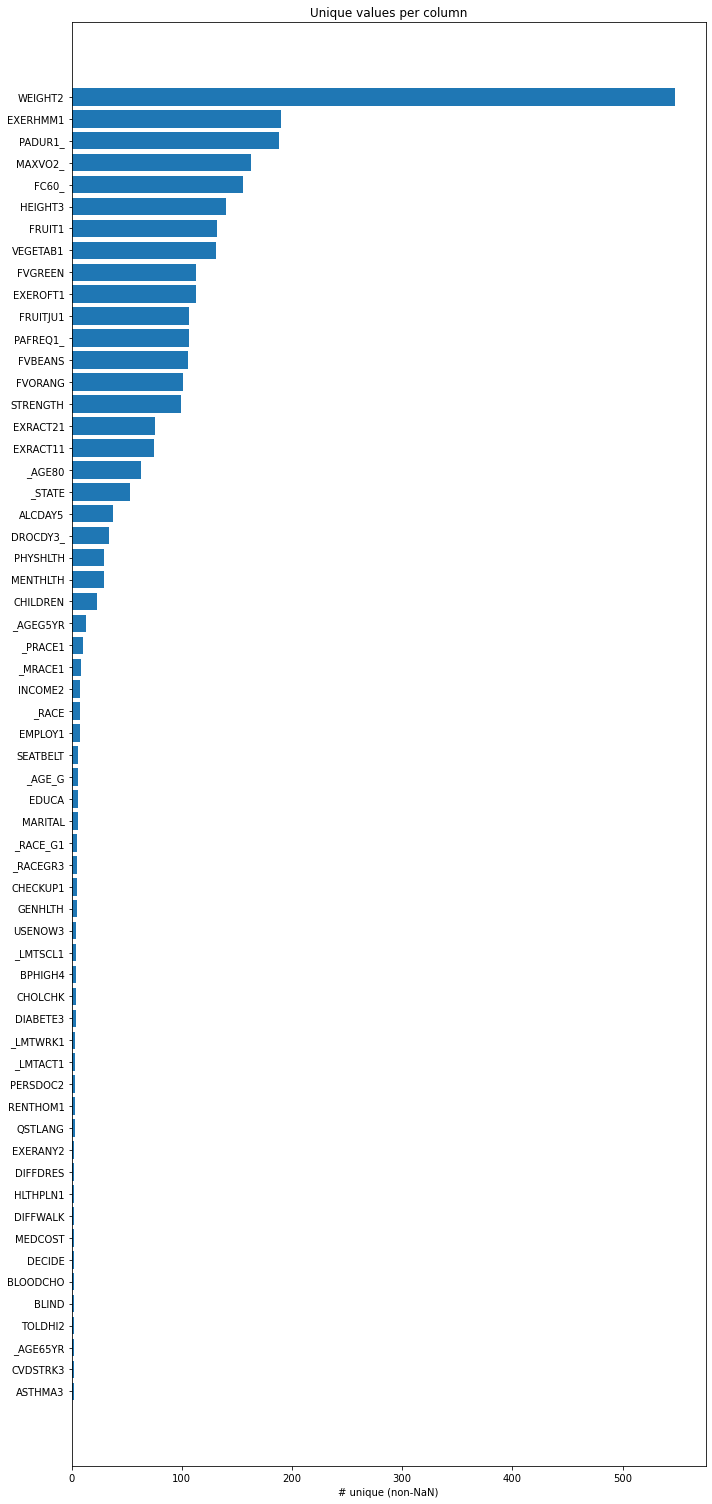

Column | #unique | %unique_of_nonmissing
WEIGHT2                   548      0.18%
EXERHMM1                  190      0.09%
PADUR1_                   188      0.09%
MAXVO2_                   163      0.05%
FC60_                     156      0.05%
HEIGHT3                   140      0.04%
FRUIT1                    132      0.04%
VEGETAB1                  131      0.04%
FVGREEN                   113      0.04%
EXEROFT1                  113      0.05%
FRUITJU1                  107      0.04%
PAFREQ1_                  107      0.06%
FVBEANS                   106      0.04%
FVORANG                   101      0.03%
STRENGTH                   99      0.03%
EXRACT21                   76      0.04%
EXRACT11                   75      0.03%
_AGE80                     63      0.02%
_STATE                     53      0.02%
ALCDAY5                    38      0.01%
DROCDY3_                   34      0.01%
PHYSHLTH                   29      0.01%
MENTHLTH                   29      0.01%
CHILDREN        

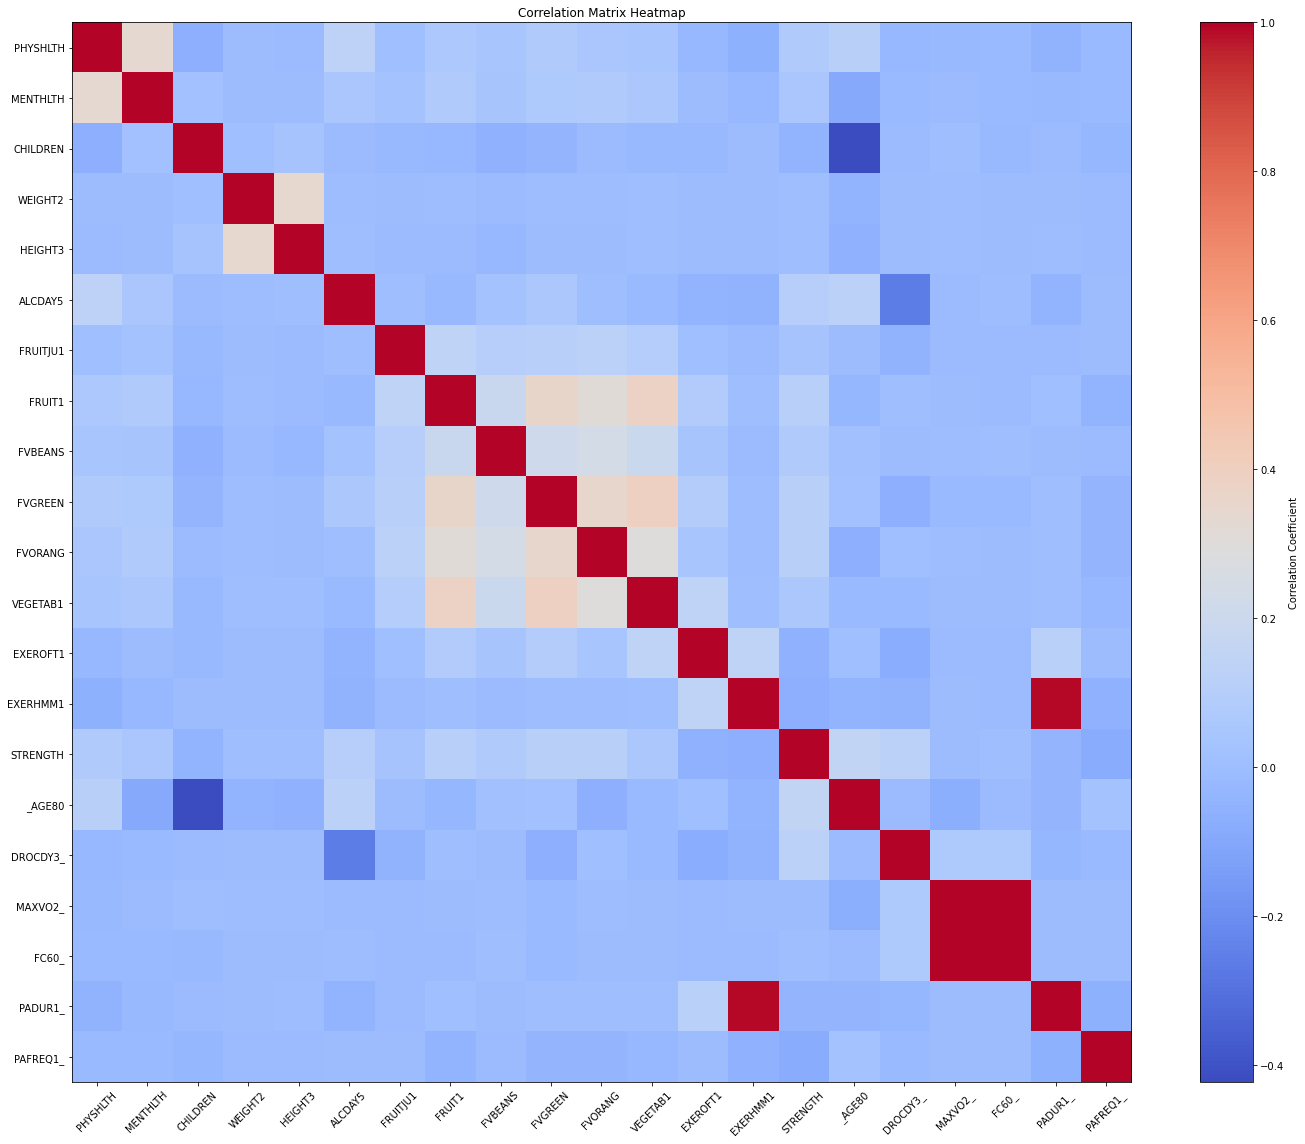

[high_corr_pairs:train] threshold=|r|>=0.90  total=2
  MAXVO2_ ~ FC60_   r=0.998 (+)
  EXERHMM1 ~ PADUR1_   r=0.993 (+)
Dropped: ['FC60_', 'PADUR1_']
New shape: (328135, 19)
Standardised numeric X (328135, 19) 
 ['PHYSHLTH', 'MENTHLTH', 'CHILDREN', 'WEIGHT2', 'HEIGHT3', 'ALCDAY5', 'FRUITJU1', 'FRUIT1', 'FVBEANS', 'FVGREEN', 'FVORANG', 'VEGETAB1', 'EXEROFT1', 'EXERHMM1', 'STRENGTH', '_AGE80', 'DROCDY3_', 'MAXVO2_', 'FC60_', 'PADUR1_', 'PAFREQ1_']
X final 
 (328135, 442)
[[ 0.          1.          0.         ... -0.30643021 -0.1233834
  -0.60546915]
 [ 0.          1.          0.         ...  0.2139144  -0.10698043
  -0.10426043]
 [ 0.          1.          0.         ... -0.23878541 -0.15128732
  -0.10426043]
 ...
 [ 0.          1.          0.         ... -0.30643021 -0.16175128
   0.39694829]
 [ 0.          1.          0.         ... -0.30643021 -0.03439254
  -1.37382211]
 [ 0.          0.          0.         ... -0.30643021 -0.10245547
   0.39694829]]


In [9]:
CSV_PATH = "data/dataset/x_train.csv"
threshold_percent = 40

#Data loading 
X, feature_names = load_data(CSV_PATH)
print("Original X", "\n", X.shape)

#Removing columns with threshold % of missing values 
plot_missingness(X)

X_rem_missing, feature_names_rem_missing = compute_missing(X, feature_names,threshold_percent)
print("Post missingness X", "\n", X_rem_missing.shape)

# remove specific administrative/date/ID columns
admin_cols = ['Id', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR',
               'DISPCODE', 'SEQNO', '_PSU', 'QSTVER', 'MSCODE', '_STSTR']

# Columns that are calculated/derived from other columns in the list are removed. 
calculated_cols = [
    "_RFHLTH", "_HCVU651", "_RFHYPE5", "_CHOLCHK", "_RFCHOL",
    "_LTASTH1", "_CASTHM1", "_ASTHMS1", "_DRDXAR1",
    "HTIN4", "HTM4", "WTKG3", "_BMI5", "_BMI5CAT", "_RFBMI5",
    "_CHLDCNT", "_EDUCAG", "_INCOMG",
    "_SMOKER3", "_RFSMOK3","DRNKANY5",
    "_DRNKWEK", "_RFBING5", "_RFDRHV5",
    "FTJUDA1_", "FRUTDA1_", "BEANDAY_", "GRENDAY_", "ORNGDAY_", "VEGEDA1_",
    "_MISFRTN", "_MISVEGN", "_FRTRESP", "_VEGRESP",
    "_FRUTSUM", "_VEGESUM", "_FRTLT1", "_VEGLT1", "_FRT16", "_VEG23", "_FRUITEX", "_VEGETEX",
    "METVL11_", "ACTIN11_", "_MINAC11",
    "METVL21_", "ACTIN21_", "_MINAC21",
    "STRFREQ_", "PAMISS1_", "PAMIN11_", "PAMIN21_",
    "PA1MIN_", "PAVIG11_", "PAVIG21_", "PA1VIGM_",
    "_PACAT1", "_PAINDX1", "_PA150R2", "_PA300R2", "_PA30021",
    "_PASTRNG", "_PAREC1", "_PASTAE1",
    "_TOTINDA",
    "_RFSEAT2", "_RFSEAT3", "_AIDTST3","_RACEG21"
]

# Removing "weights assigned to each respondent" - hidden data in the dataset
weights = ["_STRWT","_RAWRAKE","_WT2RAKE","_DUALUSE","_DUALCOR","_LLCPWT"]

cols_to_remove = admin_cols+calculated_cols+weights

X_reduced, feature_names_reduced = remove_cols(X_rem_missing, feature_names_rem_missing, cols_to_remove)
print("Post manual removal X", "\n", X_reduced.shape)

# ---------- Default superset: covers DK/Refused across BRFSS ----------
DEFAULT_MISS = np.array([7, 9, 77, 99, 777, 999], dtype=float)

# Columns that need a DIFFERENT code set (override the default)
SPECIAL_MISS = {
    # only 9 means missing
    "_PRACE1": [9], "_MRACE1": [9], "_HISPANC": [9], "_RACE": [9],
    "_RACEGR3": [9], "_RACE_G1": [9], "EMPLOY1": [9], "USENOW3": [9],
    "MARITAL": [9], "EDUCA": [9], "QSTLANG": [9], "_AGE65YR": [9],
    "_AGE80": [9], "_AGE_G": [9],

    # activity type uses 77/99 only
    "EXRACT11": [77, 99], "EXRACT21": [77, 99],

    # children/income use 77/99
    "CHILDREN": [77, 99], "INCOME2": [77, 99],

    # special case: age bins (keep 1..13)
    "_AGEG5YR": [14], "_AGE65YR" : [3],
    
    # weight/height uses 7777,9999
    "WEIGHT2" : [7777,9999], "HEIGHT3": [7777,9999],"MAXVO2_": [7777, 9999],
    "FC60_":   [7777, 9999],
    
    # has its own list 
    "_STATE" : [7,77,99, 777, 999]
    
}

SPECIAL_TO_ZERO = {"PHYSHLTH": 88, "MENTHLTH": 88, "CHILDREN": 88}  # add others ONLY if codebook says 88 = None there

# Replacing default blank/missing/unk values with nan 
X_clean = clean_data(X_reduced,feature_names_reduced)
print("Post nan filling X", "\n", X_clean.shape)

# Plotting unique values per variable to help create algorithm to determine numerical vs categorical variables  
uniq_counts, prop_unique = plot_unique_counts(
    X_clean, feature_names_reduced,
    top_n=60,            # show top 60 most unique; set None to show all
    sort_desc=True,
    filename="unique_counts.png"
)

#Splitting dataset into columns that should be imputed with median (numeric) vs mode (categorical)
mode_cols, median_cols = impute_plan(
    X_clean, feature_names_reduced,
    abs_unique_cap=76,           # if #unique < abs_unique_cap  -> categorical (mode)
    rel_unique_cap=0.04,         # if %unique < rel_unique_cap  -> categorical (mode)
    singleton_ratio_thresh=0.60, # if ≥ threshold occur once    -> numeric (median)
    force_mode = {"_STATE","EXRACT11","EXRACT21"},             # e.g., {"_STATE","EXRACT11","EXRACT21"}
    force_median=None)
    
#Imputing dataset based on above created plan 
save_path = "data/dataset/impute_vals"
X_impute, fillers = impute(X_clean, feature_names_reduced,mode_cols, median_cols,save_path)
print("Post imputation X", "\n", X_impute.shape)

# Split categorical columns into binary vs ordinal columns and perform one-hot encoding 
binary_cols, ohe_cols, constant_cols = identify_cat_cols(X_impute, feature_names_reduced, mode_cols, verbose=True)

X_bin_tr, binary_tr_cols  = build_binary_matrix(X_impute, feature_names_reduced, binary_cols)
print("Binary X", "\n", X_bin_tr.shape, "\n",binary_cols)

if perform_one_hot:
    X_ohe_tr, ohe_tr_cols = fit_ohe_and_save(
        X_impute, feature_names_reduced, ohe_cols,
        save_path="data/dataset/onehot_model.npz",
        include_missing=True, use_other=True, min_count=1, drop_first=False, verbose=True
    )

else:
    X_ohe_tr, ohe_tr_cols, ohe_idx, missing = extract_columns_by_name(
    X_impute, feature_names_reduced, ohe_cols, strict=True
    )
    
#print("are both versions of binary columns the same?", binary_cols = binary_tr_cols)
#print("are both versions of ohe columns the same?", ohe_cols = ohe_tr_cols)

print("OHE X", "\n", X_ohe_tr.shape,"\n",ohe_cols)

#Extract numeric columns for additional analyses

X_numeric, num_names, num_idx, missing = extract_columns_by_name(
    X_impute, feature_names_reduced, median_cols, strict=True
)
print("Numeric X", "\n",X_numeric.shape, "\n",num_names)

# Perform correlation and plot heat map. Drop highly correlated features 
corr_matrix = plot_heat_map(X_numeric, num_names)

pairs = high_corr_pairs(corr_matrix, num_names, threshold=0.90, top_k=None, label="train")

# Suppose 'pairs' came from your high_corr_pairs(...) function: [(a,b,r), ...]
X_pruned, names_pruned, dropped_names, drop_idx, keep_idx = drop_correlated_seconds(
    X_numeric, num_names, pairs, strict=False
)

print("Dropped:", dropped_names)
print("New shape:", X_pruned.shape)

#Perform standardisation and PCA on numeric columns 
save_path = "data/dataset/scaler_zscore"

std = fit_standardizer(X_pruned)
save_standardizer(std, save_path)
X_std = transform_standardizer(X_pruned, std)

print("Standardised numeric X", X_std.shape, "\n", num_names)

if perform_pca:
    
    num_df = pca_fit_and_save_train(
        X_std,
        variance_threshold=0.9,
        model_path="data/dataset/pca_train_model.npz",
        csv_path="data/dataset/pca_train_projection.csv", 
        row_id_name="idx"
    )
    
    num_names = make_pc_names(num_df.shape[1])
    print("PCA X", num_df.shape)

else:
    num_df = X_std

# Combine binary, ordinal and PCA numeric data 

# after: impute → standardize numeric → PCA
# Z_num: (n x k), numeric PCs

# X_bin: (n x b), just your binary columns (0/1) in the desired order
# bin_names: their names

# X_ohe: (n x m) from your one-hot encoder
# ohe_names: the produced dummy column names

X_final, final_names = concat_design(num_df, num_names, X_bin_tr, binary_tr_cols, X_ohe_tr, ohe_tr_cols)

# sanity check
print("X final","\n",X_final.shape)
print(X_final)

In [4]:
def align_test_to_train(X_test, names_test, names_train, fill_value=np.nan, strict=False):
    """
    Reorder/select X_test columns to match names_train.
    - Drops columns in test that aren't in train.
    - If a train column is missing in test:
        * strict=True  -> raise
        * strict=False -> create a new column filled with `fill_value`
    Returns:
        X_aligned (n_test x len(names_train)), names_train (unchanged),
        missing_in_test (list), extra_in_test (list)
    """
    X_test = np.asarray(X_test)
    name_to_idx = {n:i for i,n in enumerate(names_test)}

    missing_in_test = [n for n in names_train if n not in name_to_idx]
    extra_in_test   = [n for n in names_test  if n not in set(names_train)]

    if strict and missing_in_test:
        raise KeyError(f"Missing columns in test: {missing_in_test}")

    cols = []
    for n in names_train:
        if n in name_to_idx:
            cols.append(X_test[:, name_to_idx[n]].reshape(-1,1))
        else:
            # create missing column
            col = np.full((X_test.shape[0], 1), fill_value, dtype=float)
            cols.append(col)

    X_aligned = np.concatenate(cols, axis=1) if cols else np.zeros((X_test.shape[0], 0))
    return X_aligned, list(names_train), missing_in_test, extra_in_test


In [10]:
# Apply to testing data

CSV_PATH = "data/dataset/x_test.csv"

X_test, feature_names_test = load_data(CSV_PATH)
name_to_idx = {n: i for i, n in enumerate(feature_names_test)}
print(name_to_idx)

X_test_removed, features_test_reduced, missing, extra = align_test_to_train(
    X_test, feature_names_test, feature_names_reduced, fill_value=np.nan, strict=False
)
print(features_test_reduced)

# Replacing default blank/missing/unk values with nan 
X_test_clean = clean_data(X_test_removed,features_test_reduced)
print("Post nan filling X", "\n", X_clean.shape)

# Impute
imputer_path = "data/dataset/impute_vals.npz"
X_test_impute = apply_imputer_to_test(X_test_clean, features_test_reduced, imputer_path)
print("Imputed",X_test_impute.shape)

# Split into binary and ohe and perform ohe
X_test_bin, bin_test_names  = build_binary_matrix(X_test_impute, features_test_reduced, binary_cols)
print("Binary",X_test_bin)

if perform_one_hot:
    X_test_ohe, ohe_test_names= apply_saved_ohe(X_test_impute, features_test_reduced, load_path="data/dataset/onehot_model.npz", strict=True)
else:
    X_test_ohe, ohe_test_names, ohe_idx, missing = extract_columns_by_name(
    X_test_impute, features_test_reduced, ohe_cols, strict=True )    
print("ohe",X_test_ohe)

#Extract numeric columns and perform analyses 
X_test_numeric, test_num_names, test_num_idx, missing = extract_columns_by_name(X_test_impute, features_test_reduced, median_cols, strict=True)
X_test_corr, feature_names_corr_reduced, dropped_names, drop_idx, keep_idx = drop_correlated_seconds(X_test_numeric, test_num_names, pairs, strict=False)
standardiser = load_standardizer(path="data/dataset/scaler_zscore.npz")
X_test_std = transform_standardizer(X_test_corr, standardiser)

if perform_pca:
    X_test_numeric = pca_transform(X_test_std, model_path="data/dataset/pca_train_model.npz")
    test_num_names = make_pc_names(X_test_numeric.shape[1], prefix="PC")

X_test_final, final_test_names  = concat_design(X_test_numeric, test_num_names, X_test_bin, bin_test_names, X_test_ohe, ohe_test_names)

print(X_test_final.shape)

{'Id': 0, '_STATE': 1, 'FMONTH': 2, 'IDATE': 3, 'IMONTH': 4, 'IDAY': 5, 'IYEAR': 6, 'DISPCODE': 7, 'SEQNO': 8, '_PSU': 9, 'CTELENUM': 10, 'PVTRESD1': 11, 'COLGHOUS': 12, 'STATERES': 13, 'CELLFON3': 14, 'LADULT': 15, 'NUMADULT': 16, 'NUMMEN': 17, 'NUMWOMEN': 18, 'CTELNUM1': 19, 'CELLFON2': 20, 'CADULT': 21, 'PVTRESD2': 22, 'CCLGHOUS': 23, 'CSTATE': 24, 'LANDLINE': 25, 'HHADULT': 26, 'GENHLTH': 27, 'PHYSHLTH': 28, 'MENTHLTH': 29, 'POORHLTH': 30, 'HLTHPLN1': 31, 'PERSDOC2': 32, 'MEDCOST': 33, 'CHECKUP1': 34, 'BPHIGH4': 35, 'BPMEDS': 36, 'BLOODCHO': 37, 'CHOLCHK': 38, 'TOLDHI2': 39, 'CVDSTRK3': 40, 'ASTHMA3': 41, 'ASTHNOW': 42, 'CHCSCNCR': 43, 'CHCOCNCR': 44, 'CHCCOPD1': 45, 'HAVARTH3': 46, 'ADDEPEV2': 47, 'CHCKIDNY': 48, 'DIABETE3': 49, 'DIABAGE2': 50, 'SEX': 51, 'MARITAL': 52, 'EDUCA': 53, 'RENTHOM1': 54, 'NUMHHOL2': 55, 'NUMPHON2': 56, 'CPDEMO1': 57, 'VETERAN3': 58, 'EMPLOY1': 59, 'CHILDREN': 60, 'INCOME2': 61, 'INTERNET': 62, 'WEIGHT2': 63, 'HEIGHT3': 64, 'PREGNANT': 65, 'QLACTLM2': 66

ohe [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]]
(109379, 444)


In [11]:
np.savetxt(
        "data/dataset/X_train_preprocessed_251025.csv",
        X_final,
        delimiter=",",
        header=",".join(final_names),
        comments=""              # no leading '#'
    )

np.savetxt(
        "data/dataset/X_test_preprocessed_251025.csv",
        X_test_final,
        delimiter=",",
        header=",".join(final_test_names),
        comments=""              # no leading '#'
    )